In [152]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import pickle

from ising_model import Ising2DWolff
from monte_carlo import wolff_algorithm


np.random.seed(0)
torch.manual_seed(0)


def run_exp(L, step_num, T, continue_run=False):
    if continue_run:
        logger = load_logger(L, step_num, T)

        ising = Ising2DWolff(L, logger.states[-1])
    else:
        ising = Ising2DWolff(L, )
    logger = wolff_algorithm(ising, T, step_num, flip_all=False, logger=logger if continue_run else None)
    pickle.dump(logger, open(f'./save/2d_ising_model_L={L}_T={T}_step_num={step_num}.pkl', 'wb'))
    return logger


def load_logger(L, step_num, T):
    logger = pickle.load(open(f'./save/2d_ising_model_L={L}_T={T}_step_num={step_num}.pkl', 'rb'))
    return logger



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
logger = run_exp(10, 1000, 2.1)
fig, ax = plt.subplots(1, 1)
ax.plot(logger.states[:, 0, :, :].mean((-1, -2)))

100%|██████████| 1000/1000 [00:11<00:00, 86.64it/s]


In [ ]:
# run and save

np.random.seed(0)
torch.manual_seed(0)
for T in np.linspace(1, 3, 20):
    for L in [15]:
        run_exp(L, 3000, T, continue_run=False)

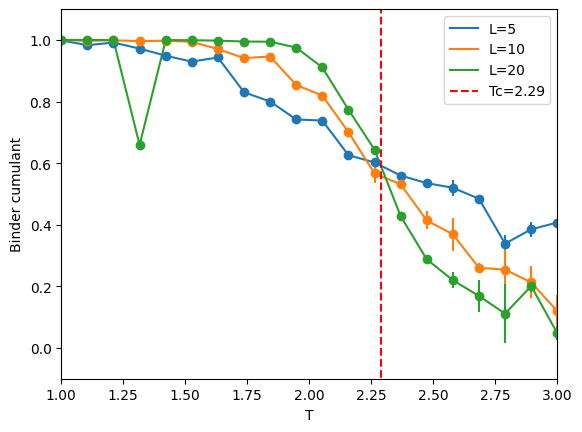

In [263]:
fig, ax = plt.subplots(1, 1)

def binder(spins, bin=3):
    binders = []
    for i in range(bin):
        # spins_leaveout = np.vstack((spins[:i * bin], spins[(i + 1) * bin: ]))
        spins_leaveout = spins[i::bin]
        m2 = (spins_leaveout.mean((-1, -2))**2).mean()
        m4 = (spins_leaveout.mean((-1, -2))**4).mean()
        binder = 1.5 - (m4 / (2 * m2 ** 2))
        binders.append(binder)
    binders = np.array(binders)
    # use jackknife to estimate std
    std = np.sqrt(((binder - binders)**2).sum() / (len(binders) - 1))
    
    return binders.mean(), std

# Ts = np.linspace(1, 3, 100):
Ts = np.linspace(1, 3, 20)
for i, L in enumerate([5, 10, 20]):
    m_T = []
    b_T, b_T_std = [], []
    for T in Ts:
        logger = load_logger(L, 3000, T)
        m = logger.states[-400::10, 0, :, :].mean((-1, -2)).abs().mean()
        m_T.append(m)
        b, b_std = binder(logger.states[1000:, 0, :, :])
        b_T.append(b)
        b_T_std.append(b_std)
    ax.plot(Ts, b_T, label=f'L={L}', color=f'C{i}')
    ax.errorbar(Ts, b_T, yerr=[x for x in b_T_std], fmt='o', color=f'C{i}')
    
ax.plot([2.29, 2.29], [-1, 10], label='Tc=2.29', color='red', ls='--')
ax.legend()
ax.set_xlabel('T')
ax.set_ylabel('Binder cumulant')
ax.set_xlim(1, 3)
ax.set_ylim(-0.1, 1.1)
fig.savefig('./images/ising_2d_binder.png')

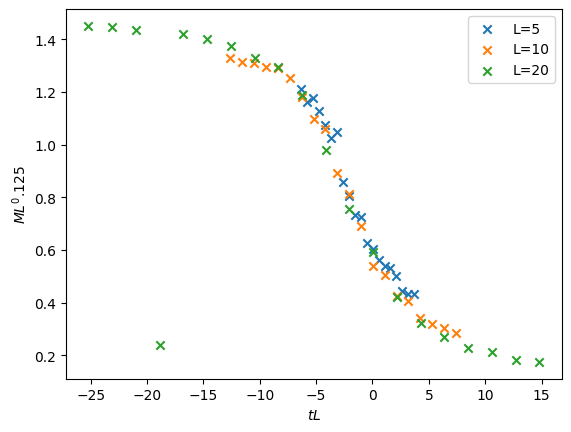

In [255]:
get_m = lambda spin: spin.mean((-1, -2)).abs().mean()


a, b = 0.125, 1
Tc = 2.26

fig, ax = plt.subplots(1, 1)
Ts = np.linspace(1, 3, 20)
for i, L in enumerate([5, 10, 20]):
    m_T = []
    for T in Ts:
        logger = load_logger(L, 3000, T)
        m = get_m(logger.states[1000:, 0])
        m_T.append(m)
    m_T = np.array(m_T)

    ax.scatter((Ts - Tc) * L ** b, m_T * L ** a, label=f'L={L}', color=f'C{i}', marker='x')

# ax.set_xscale('log')
# ax.set_yscale('log')
   
ax.legend()
ax.set_xlabel('$tL$')
ax.set_ylabel('$ML^0.125$')
fig.savefig('./images/ising_2d_general.png')

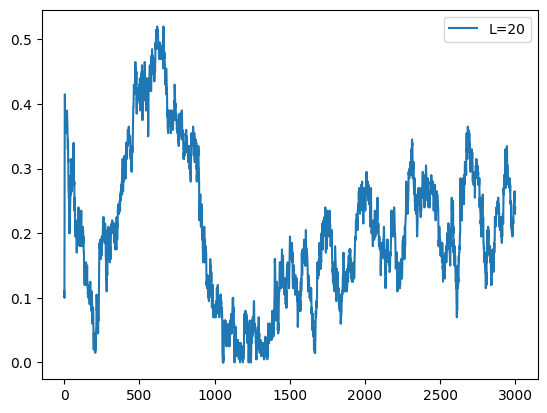

In [236]:
fig, ax = plt.subplots(1, 1)
i = 3
Ts = np.linspace(1, 3, 20)[i: i + 1]
for L in [20]:
    m_T = []
    b_T = []
    for T in Ts:
        logger = load_logger(L, 3000, T)
        
ax.plot(logger.states[:, 0, ...].mean((-1, -2)).abs(), label=f'L={L}')
ax.legend()